In [31]:
import pytreebank
import numpy as np
import torch
import sys
import argparse
from glove_reader import GloveReader
from gensim.utils import tokenize
import itertools
from model import RNN
import time
from dataloader import SST
import pandas as pd

def transform_and_pad(data):
    """
        Given the input dataset, returns three tensors of the padded data (on the left!)
        Returns:
            content - Tensor Nxd
            labels  - Tensor Nx1
            mask    - Tensor Nxd (binary)
        
    """
    max_len = max(map(lambda x: len(x[1:]), data))
    labels = torch.tensor(list(map(lambda x: x[0], data)))
    data = list(map(lambda x: x[1:], data))
    content = torch.tensor([(0,)*(max_len - len(x)) + x for x in data])
    content_mask = torch.tensor([(0,)*(max_len - len(x)) + (1,) * len(x) for x in data])
    return content, labels, content_mask

In [2]:
def validate(model, dev_dataset):
    dev = torch.utils.data.DataLoader(dev_dataset, batch_size=len(dev_dataset), num_workers=4, shuffle=False)
    
    model.eval()
    
    loss_fn = torch.nn.CrossEntropyLoss()

    total_count = 0
    num_correct = 0
    tot_loss = 0.0
    
    for batch in dev:
        data, labels, mask = batch
        
        output = model(data,mask)
        tot_loss += loss_fn(output, labels).item()
        
        pred = torch.argmax(output, 1)
        num_correct += (pred == labels).sum().item()
        total_count += pred.size(0)

    model.train()
    return num_correct / total_count, tot_loss


In [66]:
def train(model, train_dataset, dev_dataset, max_epochs=50, model_name='model.save', stopping_counter=10):

    losses = []
    accs = []
    dev_losses = []
    dev_accs = []
    
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss()
    
    best_loss = float('+inf')
    best_model = model
    
    counter = 0
    
    train = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
    model.train()
    for epoch in range(max_epochs):
        print("-" * 10 , "EPOCH ", epoch,  "-"*10)
        
        num_correct = 0.0
        total_count = 0.0
        start = time.time()
        epoch_loss = 0.0
        
        for i, batch in enumerate(train):
            if i + 1 % 100 == 0:
                print('Batch ', i)
            
            data, labels, mask = batch
            
            optimizer.zero_grad()

            output = model(data, mask)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(output, 1)
            num_correct += (pred == labels).sum().item()
            total_count += pred.size(0)
            epoch_loss += loss.item()
        
        
        losses.append(epoch_loss / (i+1))
        accs.append(num_correct / total_count)
    
        end = time.time()
        
        counter += 1 # for early stopping
        
        eval_acc, eval_loss = validate(model, dev_dataset)
        
        print(f'Loss={losses[-1]}, Accuracy={accs[-1]}, Dev Accuracy={eval_acc}, epoch took {end - start}s')
        
        dev_losses.append(eval_loss)
        dev_accs.append(eval_acc)
        
        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model = model
            counter = 0
            print("Saving new best model...")
            torch.save(best_model.state_dict(), model_name)
        
        
        if counter == stopping_counter:
            return losses, accs, dev_losses, dev_accs



In [4]:
def load_data(path):
    data = pytreebank.import_tree_corpus(path)
    data = list(map(lambda x: x.to_labeled_lines()[0], data))

    # tokenizes and filters those words that exist in the dictionary for each example
    data = list(map(lambda x: (x[0], list(filter(lambda x: x in glove.words2idx, tokenize(x[1], lower=True)))), data))

    # transforms words into numbers
    data = list(map(lambda x: (x[0],*list(map(lambda y: glove.words2idx[y], x[1]))), data))

    # pad data and transform tensor
    content, labels, mask = transform_and_pad(data)
    del data
    
    return content, labels, mask

In [5]:
#loads glove embeddings
glove = GloveReader()

In [6]:
#load train dataset
train_data = SST(*load_data('./trees/train.txt'))

In [7]:
# load dev dataset
dev_data = SST(*load_data('./trees/dev.txt'))

In [67]:
m  = RNN(300, 2, 128, 5, pretrained_embeddings=glove.embeddings, dropout=0.2)

In [68]:
losses, accs, dev_losses, dev_accs = train(m, train_data, dev_data, model_name="dropout_model.save")

---------- EPOCH  0 ----------
Loss=1.5560051861094004, Accuracy=0.3154260299625468, Dev Accuracy=0.3387829246139873, epoch took 7.925465822219849s
Saving new best model...
---------- EPOCH  1 ----------
Loss=1.5615971355295892, Accuracy=0.3089887640449438, Dev Accuracy=0.3605812897366031, epoch took 8.220098972320557s
Saving new best model...
---------- EPOCH  2 ----------
Loss=1.5364269347333197, Accuracy=0.34913389513108617, Dev Accuracy=0.3133514986376022, epoch took 7.814146280288696s
---------- EPOCH  3 ----------
Loss=1.5417403258494478, Accuracy=0.3404728464419476, Dev Accuracy=0.36603088101725706, epoch took 7.788623571395874s
Saving new best model...
---------- EPOCH  4 ----------
Loss=1.5015873926789014, Accuracy=0.382373595505618, Dev Accuracy=0.3614895549500454, epoch took 7.713435649871826s
Saving new best model...
---------- EPOCH  5 ----------
Loss=1.493743078922158, Accuracy=0.39302434456928836, Dev Accuracy=0.39691189827429607, epoch took 7.770105361938477s
Saving new

<AxesSubplot:>

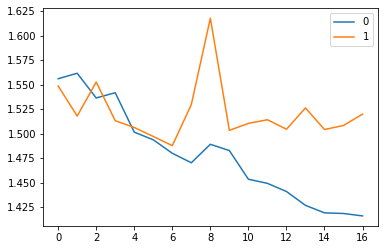

In [73]:
pd.DataFrame(np.array([losses,dev_losses]).T).plot()

([0.3061797752808989,
  0.3669241573033708,
  0.3819054307116105,
  0.39091760299625467,
  0.399812734082397,
  0.39922752808988765,
  0.43586142322097376,
  0.4324672284644195,
  0.4442883895131086,
  0.4544709737827715,
  0.47401685393258425,
  0.46898408239700373],
 [0.3578564940962761,
  0.3605812897366031,
  0.35149863760217986,
  0.3860127157129882,
  0.3960036330608538,
  0.36239782016348776,
  0.3860127157129882,
  0.3905540417801998,
  0.329700272479564,
  0.36603088101725706,
  0.37329700272479566,
  0.35513169845594916])

<AxesSubplot:>

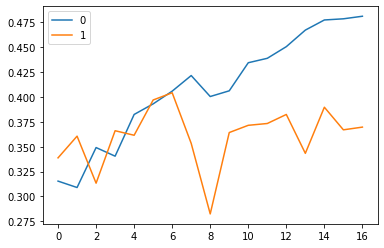

In [70]:
pd.DataFrame(np.array([accs, dev_accs])).T.plot()